**predicting turbine energy yield (TEY) using ambient variables as features.**

In [ ]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
from imblearn.pipeline import Pipeline
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils
from keras.constraints import maxnorm
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

In [ ]:
df=pd.read_csv('gas_turbines.csv')
df

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,6.8594,1007.9,96.799,3.5000,19.663,1059.2,550.00,114.70,10.605,3.1547,82.722
1,6.7850,1008.4,97.118,3.4998,19.728,1059.3,550.00,114.72,10.598,3.2363,82.776
2,6.8977,1008.8,95.939,3.4824,19.779,1059.4,549.87,114.71,10.601,3.2012,82.468
3,7.0569,1009.2,95.249,3.4805,19.792,1059.6,549.99,114.72,10.606,3.1923,82.670
4,7.3978,1009.7,95.150,3.4976,19.765,1059.7,549.98,114.72,10.612,3.2484,82.311
...,...,...,...,...,...,...,...,...,...,...,...
15034,9.0301,1005.6,98.460,3.5421,19.164,1049.7,546.21,111.61,10.400,4.5186,79.559
15035,7.8879,1005.9,99.093,3.5059,19.414,1046.3,543.22,111.78,10.433,4.8470,79.917
15036,7.2647,1006.3,99.496,3.4770,19.530,1037.7,537.32,110.19,10.483,7.9632,90.912
15037,7.0060,1006.8,99.008,3.4486,19.377,1043.2,541.24,110.74,10.533,6.2494,93.227


Data Exploration

In [ ]:
df.isnull().any()

AT      False
AP      False
AH      False
AFDP    False
GTEP    False
TIT     False
TAT     False
TEY     False
CDP     False
CO      False
NOX     False
dtype: bool

In [ ]:
df.isnull().sum()

AT      0
AP      0
AH      0
AFDP    0
GTEP    0
TIT     0
TAT     0
TEY     0
CDP     0
CO      0
NOX     0
dtype: int64

Descriptive Analysis

In [ ]:
df.shape

(15039, 11)

In [ ]:
#Checking the data types
df.dtypes

AT      float64
AP      float64
AH      float64
AFDP    float64
GTEP    float64
TIT     float64
TAT     float64
TEY     float64
CDP     float64
CO      float64
NOX     float64
dtype: object

In [ ]:
#Unique values for every feature
df.nunique()

AT      12086
AP        540
AH      12637
AFDP    11314
GTEP     8234
TIT       706
TAT      2340
TEY      4207
CDP      3611
CO      13096
NOX     11996
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15039 entries, 0 to 15038
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      15039 non-null  float64
 1   AP      15039 non-null  float64
 2   AH      15039 non-null  float64
 3   AFDP    15039 non-null  float64
 4   GTEP    15039 non-null  float64
 5   TIT     15039 non-null  float64
 6   TAT     15039 non-null  float64
 7   TEY     15039 non-null  float64
 8   CDP     15039 non-null  float64
 9   CO      15039 non-null  float64
 10  NOX     15039 non-null  float64
dtypes: float64(11)
memory usage: 1.3 MB


In [ ]:
df[df.duplicated()].shape

(0, 11)

In [ ]:
df[df.duplicated()]

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AT,15039.0,17.764381,7.574323,0.522300,11.408000,18.1860,23.8625,34.9290
AP,15039.0,1013.199240,6.410760,985.850000,1008.900000,1012.8000,1016.9000,1034.2000
AH,15039.0,79.124174,13.793439,30.344000,69.750000,82.2660,90.0435,100.2000
AFDP,15039.0,4.200294,0.760197,2.087400,3.723900,4.1862,4.5509,7.6106
GTEP,15039.0,25.419061,4.173916,17.878000,23.294000,25.0820,27.1840,37.4020
TIT,15039.0,1083.798770,16.527806,1000.800000,1079.600000,1088.7000,1096.0000,1100.8000
TAT,15039.0,545.396183,7.866803,512.450000,542.170000,549.8900,550.0600,550.6100
TEY,15039.0,134.188464,15.829717,100.170000,127.985000,133.7800,140.8950,174.6100
CDP,15039.0,12.102353,1.103196,9.904400,11.622000,12.0250,12.5780,15.0810
CO,15039.0,1.972499,2.222206,0.000388,0.858055,1.3902,2.1604,44.1030


In [ ]:
df.corr()["TEY"].sort_values(ascending=False)

TEY     1.000000
CDP     0.988473
GTEP    0.977042
TIT     0.891587
AFDP    0.717995
AP      0.146939
NOX    -0.102631
AH     -0.110272
AT     -0.207495
CO     -0.541751
TAT    -0.720356
Name: TEY, dtype: float64

In [ ]:
numerical_features = df.describe(include=["int64","float64"]).columns
numerical_features

Index(['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO',
       'NOX'],
      dtype='object')

Data Visualization

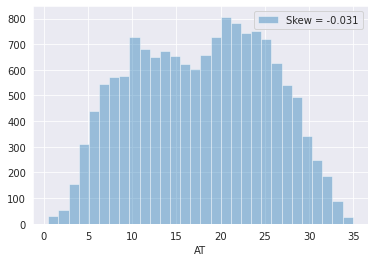

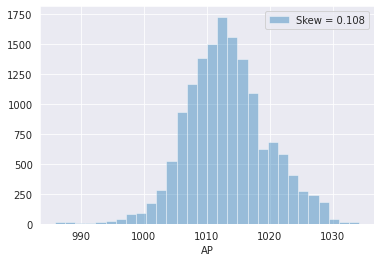

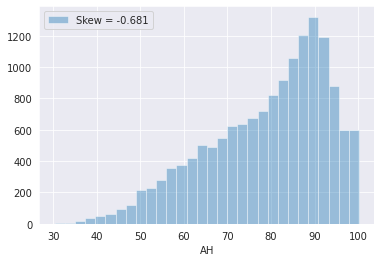

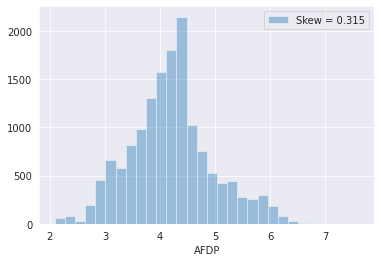

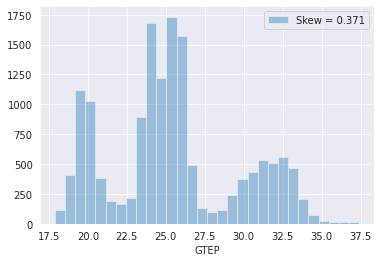

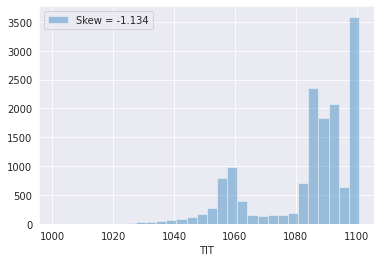

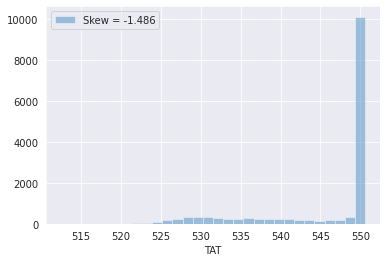

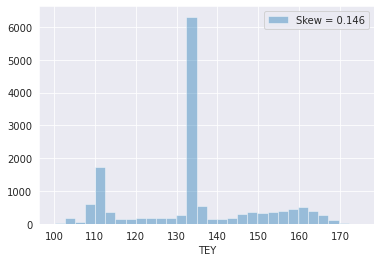

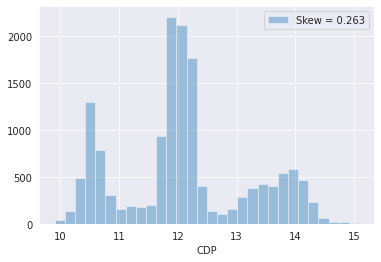

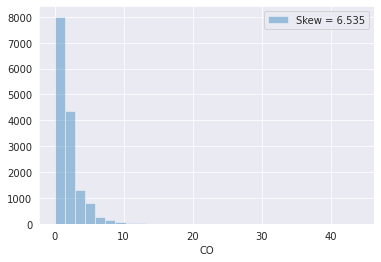

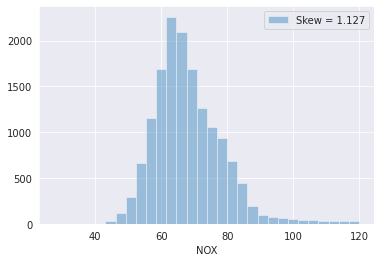

In [ ]:
numerical_features=[feature for feature in df.columns if df[feature].dtypes != 'O']
for feat in numerical_features:
    skew = df[feat].skew()
    sns.distplot(df[feat], kde= False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

In [ ]:
numerical_features

['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO', 'NOX']

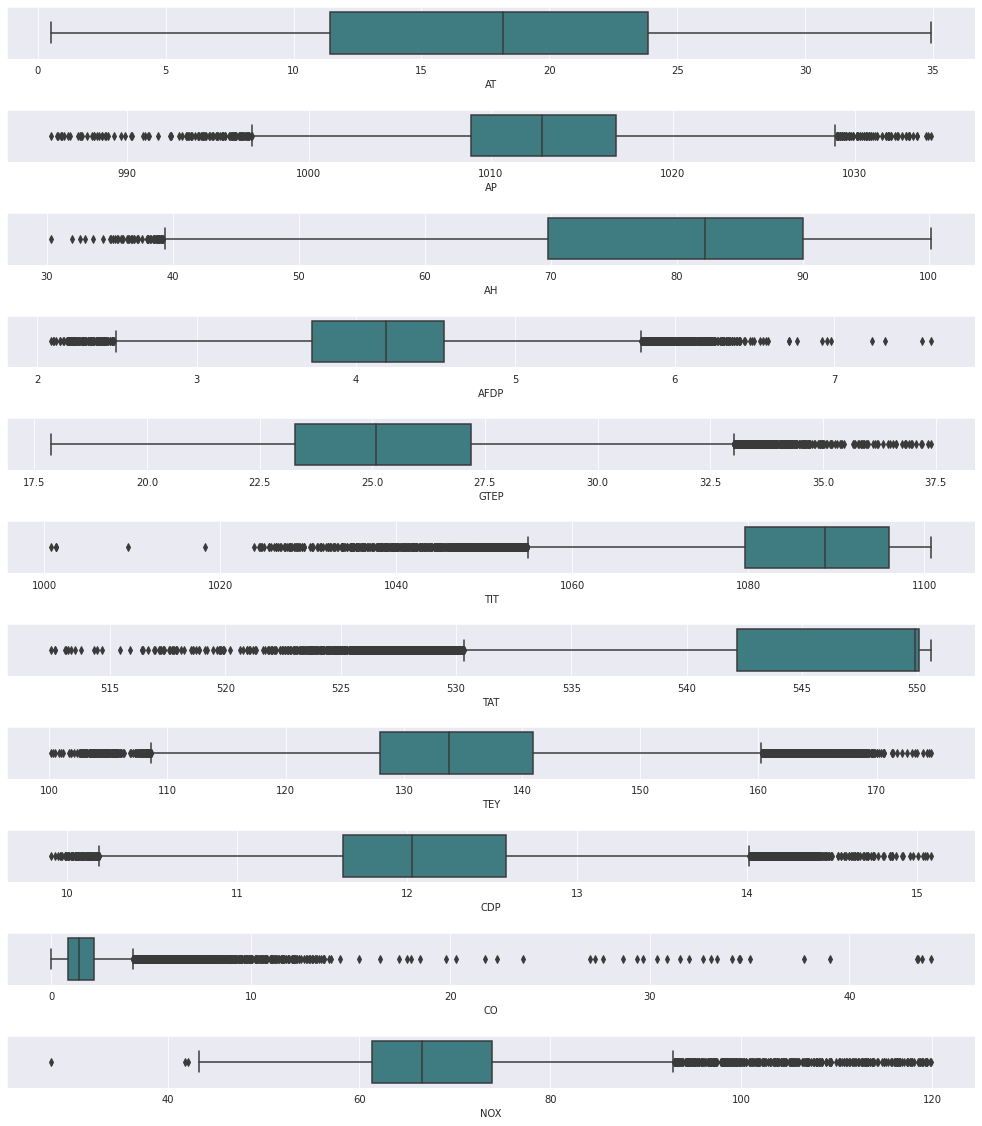

In [ ]:
ot=df.copy()
fig, axes=plt.subplots(11,1,figsize=(14,16),sharex=False,sharey=False)
sns.boxplot(x='AT',data=ot,palette='crest',ax=axes[0])
sns.boxplot(x='AP',data=ot,palette='crest',ax=axes[1])
sns.boxplot(x='AH',data=ot,palette='crest',ax=axes[2])
sns.boxplot(x='AFDP',data=ot,palette='crest',ax=axes[3])
sns.boxplot(x='GTEP',data=ot,palette='crest',ax=axes[4])
sns.boxplot(x='TIT',data=ot,palette='crest',ax=axes[5])
sns.boxplot(x='TAT',data=ot,palette='crest',ax=axes[6])
sns.boxplot(x='TEY',data=ot,palette='crest',ax=axes[7])
sns.boxplot(x='CDP',data=ot,palette='crest',ax=axes[8])
sns.boxplot(x='CO',data=ot,palette='crest',ax=axes[9])
sns.boxplot(x='NOX',data=ot,palette='crest',ax=axes[10])
plt.tight_layout(pad=2.0)

Text(0.5, 1.0, 'Histogram of the Target Column')

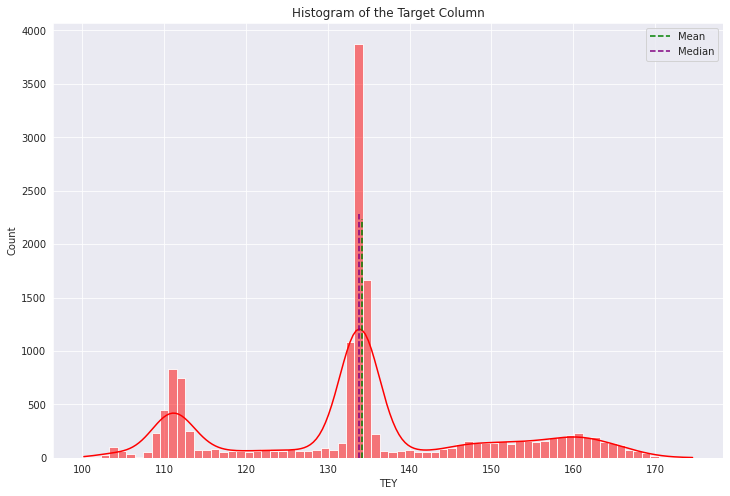

In [ ]:
sns.set_style("darkgrid")
plt.figure(figsize=(12,8))
sns.histplot(data=df,x="TEY",color="red",kde=True)
plt.axvline(x=df["TEY"].mean(),ymax=0.55,color="green",linestyle='--',label="Mean")
plt.axvline(x=df["TEY"].median(),ymax=0.56,color="purple",linestyle='--',label="Median")
plt.legend()
plt.title("Histogram of the Target Column")

Text(0.5, 1.0, 'Cumulative of the Target Column')

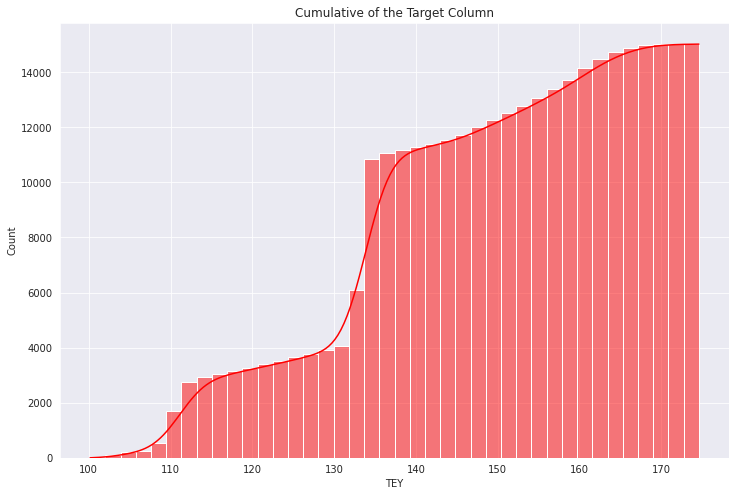

In [ ]:
plt.figure(figsize = (12,8))
sns.histplot(df["TEY"],kde=True,bins=40,color="red",cumulative=True)
plt.title("Cumulative of the Target Column")

Multivariate Analysis

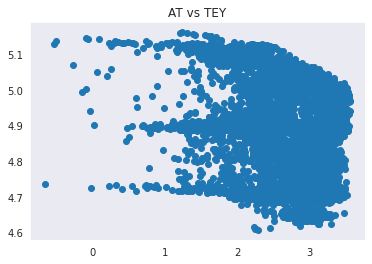

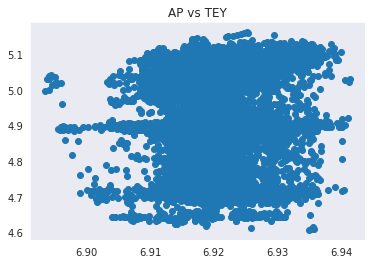

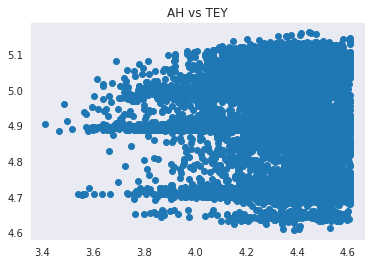

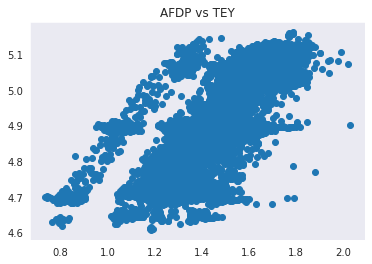

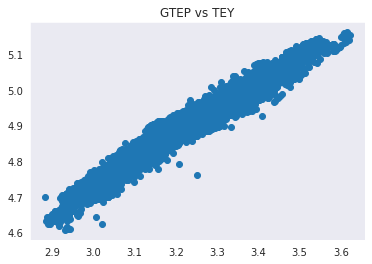

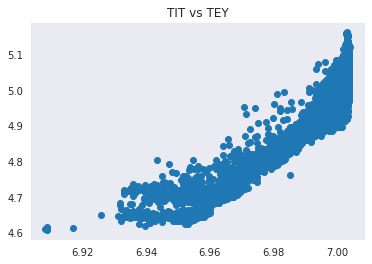

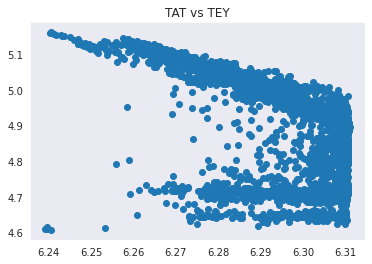

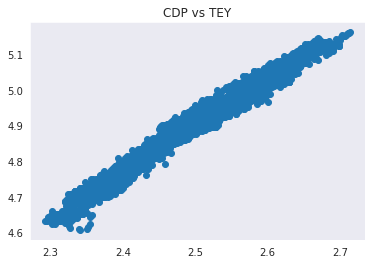

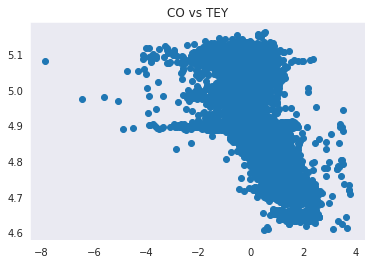

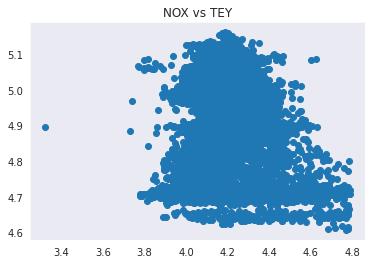

In [ ]:
for i in df.columns:
    if i!="TEY":
        plt.scatter(np.log(df[i]), np.log(df['TEY']))
        plt.title(i+ ' vs TEY')
        plt.grid()
        plt.show()

<Figure size 1440x1440 with 0 Axes>

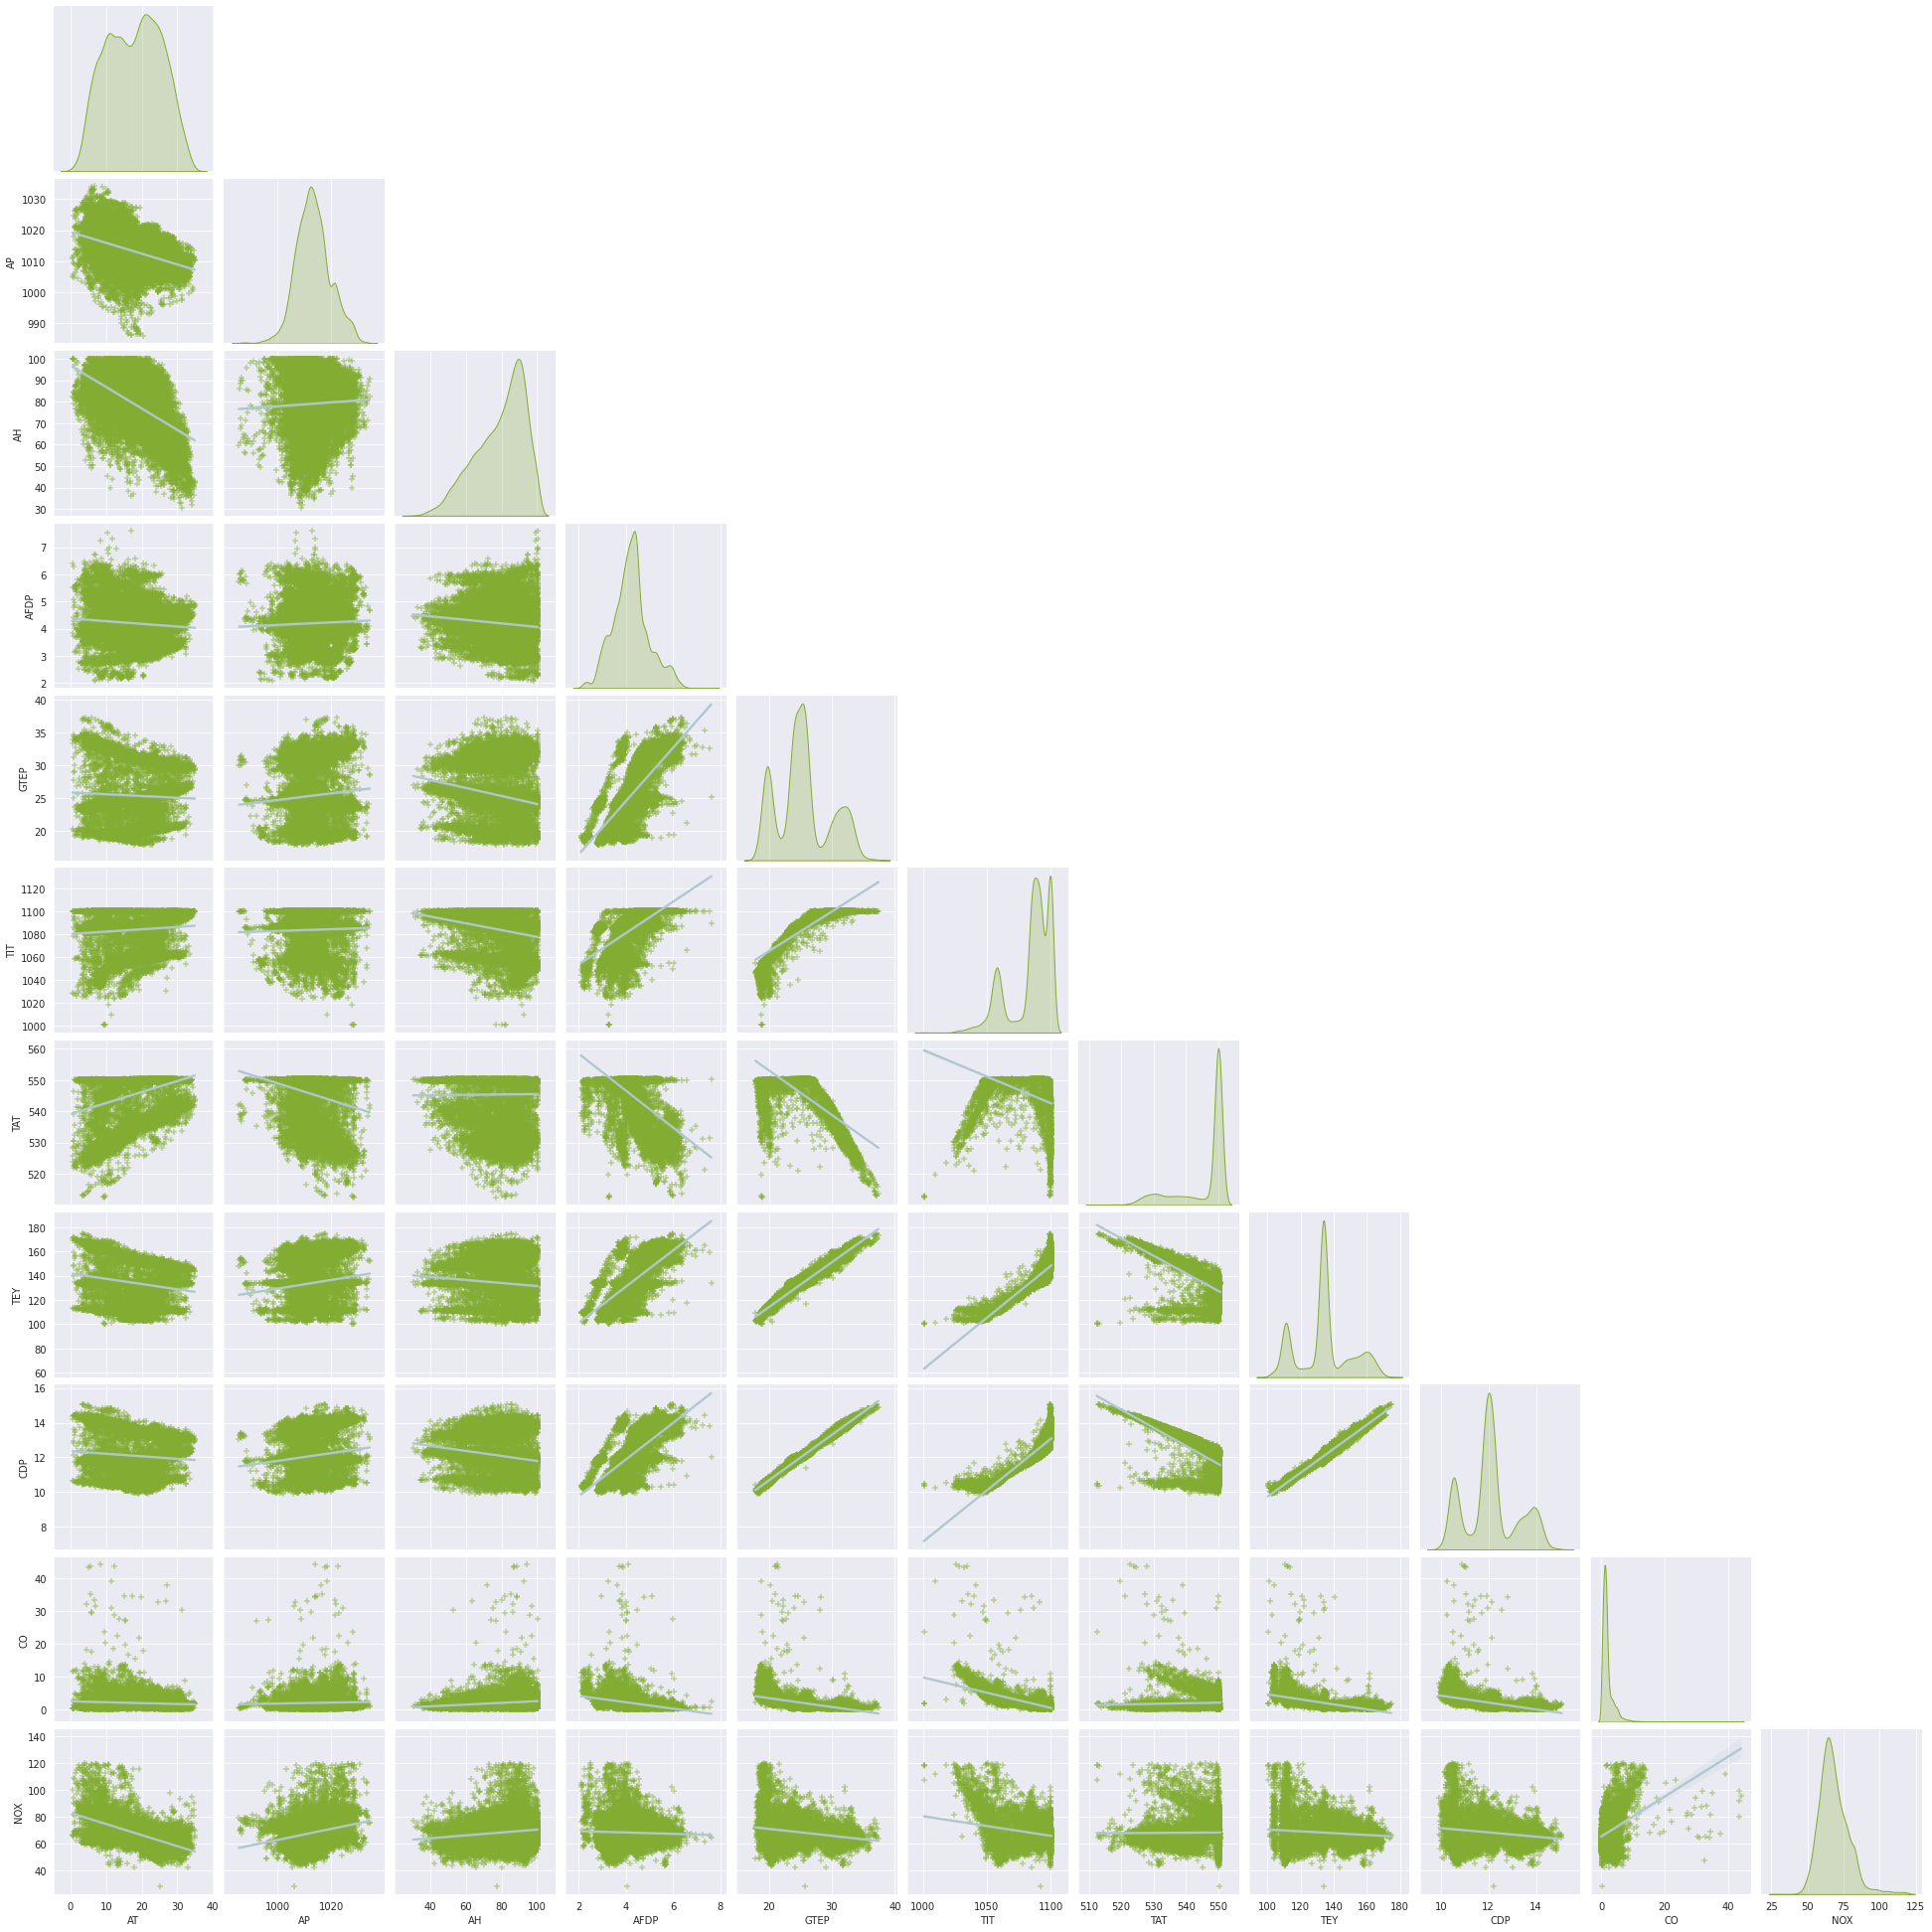

In [ ]:
plt.figure(figsize=(20,20))
sns.pairplot(df,
                 markers="+",
                 kind='reg',
                 diag_kind="kde",
                 plot_kws={'line_kws':{'color':'#aec6cf'},
                           'scatter_kws': {'alpha': 0.5,
                                           'color': '#82ad32'}},
               corner=True,
                 diag_kws= {'color': '#82ad32'})

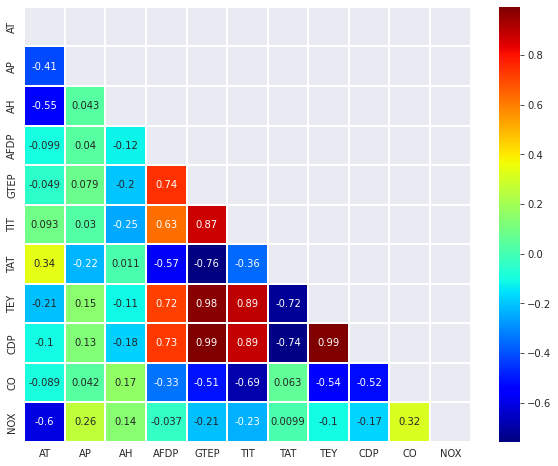

In [ ]:
# Having a look at the correlation matrix

plt.figure(figsize=(10,8))
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data=df.corr(), cmap="jet", annot=True,linewidths=1, linecolor='white',mask=mask)

In [ ]:
x = df.drop('TEY', axis=1)
y = df[["TEY"]]

Text(0.5, 1.0, 'Correlation with Turbine energy yield \n')

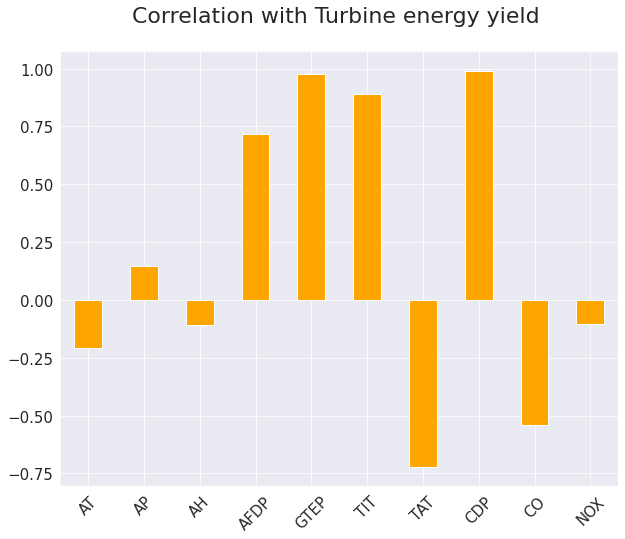

In [ ]:
data2 = df.copy()
correlations = data2.corrwith(df.TEY)
correlations = correlations[correlations!=1]
positive_correlations = correlations[correlations >0].sort_values(ascending = False)
negative_correlations =correlations[correlations<0].sort_values(ascending = False)

correlations.plot.bar(
        figsize = (10, 8),
        fontsize = 15,
        color = 'orange',
        rot = 45, grid = True)
plt.title('Correlation with Turbine energy yield \n',
horizontalalignment="center", fontstyle = "normal",
fontsize = "22", fontfamily = "sans-serif")

Feature Selection Technique

In [ ]:
#Feature importance
from numpy import set_printoptions

In [ ]:
# feature extraction
test = SelectKBest(score_func=mutual_info_regression, k='all')
fit = test.fit(x, y)

In [ ]:
# summarize scores
scores = fit.scores_
features = fit.transform(x)

In [ ]:
score_df = pd.DataFrame(list(zip(scores, x.columns)),
               columns =['Score', 'Feature'])
score_df.sort_values(by="Score", ascending=False, inplace=True)
score_df

,Score,Feature
7,1.713643,CDP
4,1.600451,GTEP
5,1.323660,TIT
6,0.893991,TAT
3,0.660233,AFDP
8,0.512513,CO
0,0.412609,AT
9,0.300835,NOX
1,0.138510,AP
2,0.097738,AH


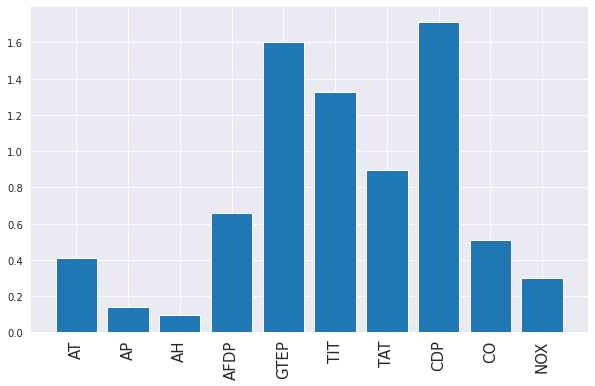

In [ ]:
fig, axes = plt.subplots(figsize=(10, 6))
plt.bar([i for i in range(len(scores))],scores)
axes.set_xticks([0,1,2,3,4,5,6,7,8,9])
axes.set_xticklabels(x.columns.values)
plt.xticks(rotation = 90, size = 15)
plt.show()

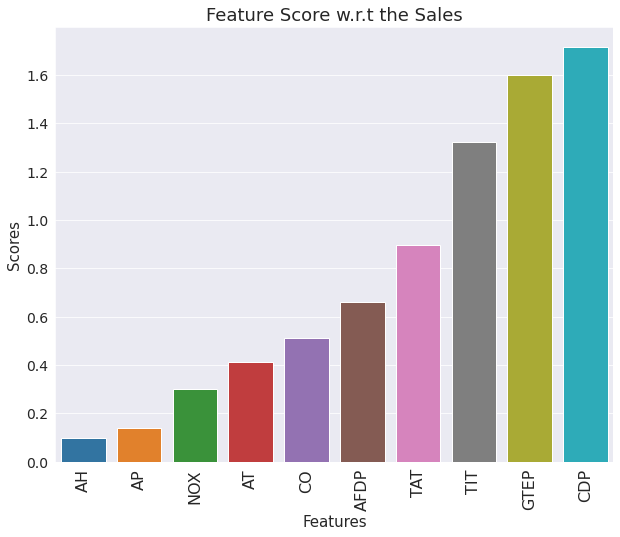

In [ ]:
plt.figure(figsize=(10,8))
# make barplot and sort bars
sns.barplot(x='Feature',
            y="Score",
            data=score_df,
            order=score_df.sort_values('Score').Feature)
# set labels
plt.xlabel("Features", size=15)
plt.ylabel("Scores", size=15)
plt.yticks(rotation = 0, fontsize = 14)
plt.xticks(rotation = 90, fontsize = 16)
plt.title("Feature Score w.r.t the Sales", size=18)
plt.show()

In [ ]:
score_df.sort_values('Score',ascending=False)

,Score,Feature
7,1.713643,CDP
4,1.600451,GTEP
5,1.323660,TIT
6,0.893991,TAT
3,0.660233,AFDP
8,0.512513,CO
0,0.412609,AT
9,0.300835,NOX
1,0.138510,AP
2,0.097738,AH


In [ ]:
model_data = df[['CDP', 'GTEP','TIT', 'TAT', 'AFDP', 'CO', 'AT',"TEY"]]
model_data.head()

,CDP,GTEP,TIT,TAT,AFDP,CO,AT,TEY
0,10.605,19.663,1059.2,550.00,3.5000,3.1547,6.8594,114.70
1,10.598,19.728,1059.3,550.00,3.4998,3.2363,6.7850,114.72
2,10.601,19.779,1059.4,549.87,3.4824,3.2012,6.8977,114.71
3,10.606,19.792,1059.6,549.99,3.4805,3.1923,7.0569,114.72
4,10.612,19.765,1059.7,549.98,3.4976,3.2484,7.3978,114.72


In [ ]:
df_standard_scaled = model_data.copy()
features = df_standard_scaled[continuous_feature]

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df_standard_scaled[continuous_feature] = scaler.fit_transform(features.values)
df_standard_scaled.head()

,CDP,GTEP,TIT,TAT,AFDP,CO,AT,TEY
0,-1.357331,-1.379101,-1.488376,0.585240,-0.921232,0.532012,-1.439778,-1.231172
1,-1.363676,-1.363528,-1.482325,0.585240,-0.921495,0.568733,-1.449601,-1.229909
2,-1.360957,-1.351309,-1.476275,0.568715,-0.944385,0.552938,-1.434721,-1.230541
3,-1.356424,-1.348194,-1.464173,0.583969,-0.946884,0.548933,-1.413702,-1.229909
4,-1.350985,-1.354663,-1.458123,0.582698,-0.924389,0.574179,-1.368693,-1.229909


The mean and standard deviation of our scaled data it should have a Mean '0' and Standard deviation '1'

In [ ]:
print('Mean' '\n',np.round(df_standard_scaled.mean(),1),'\n' 'Standard Deviation','\n',np.round(df_standard_scaled.std()),1)

Mean
 CDP     0.0
GTEP   -0.0
TIT    -0.0
TAT     0.0
AFDP    0.0
CO      0.0
AT      0.0
TEY     0.0
dtype: float64 
Standard Deviation 
 CDP     1.0
GTEP    1.0
TIT     1.0
TAT     1.0
AFDP    1.0
CO      1.0
AT      1.0
TEY     1.0
dtype: float64 1


In [ ]:
x = df.drop(labels='TEY',axis=1)
y = df[['TEY']]

In [ ]:
x

,AT,AP,AH,AFDP,GTEP,TIT,TAT,CDP,CO,NOX
0,6.8594,1007.9,96.799,3.5000,19.663,1059.2,550.00,10.605,3.1547,82.722
1,6.7850,1008.4,97.118,3.4998,19.728,1059.3,550.00,10.598,3.2363,82.776
2,6.8977,1008.8,95.939,3.4824,19.779,1059.4,549.87,10.601,3.2012,82.468
3,7.0569,1009.2,95.249,3.4805,19.792,1059.6,549.99,10.606,3.1923,82.670
4,7.3978,1009.7,95.150,3.4976,19.765,1059.7,549.98,10.612,3.2484,82.311
...,...,...,...,...,...,...,...,...,...,...
15034,9.0301,1005.6,98.460,3.5421,19.164,1049.7,546.21,10.400,4.5186,79.559
15035,7.8879,1005.9,99.093,3.5059,19.414,1046.3,543.22,10.433,4.8470,79.917
15036,7.2647,1006.3,99.496,3.4770,19.530,1037.7,537.32,10.483,7.9632,90.912
15037,7.0060,1006.8,99.008,3.4486,19.377,1043.2,541.24,10.533,6.2494,93.227


In [ ]:
y

,TEY
0,114.70
1,114.72
2,114.71
3,114.72
4,114.72
...,...
15034,111.61
15035,111.78
15036,110.19
15037,110.74


**Hyperparameter Tuning**

**Tuning of Hyperparameters :-**

1)Batch Size

2)Epochs

In [ ]:
x = df_standard_scaled.drop('TEY',axis=1)
y = df_standard_scaled[['TEY']]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=3)

In [ ]:
def create_model():
    model1 = Sequential()
    model1.add(Dense(32,input_dim=7,activation='relu'))
    model1.add(Dense(64,activation='relu'))
    model1.add(Dense(96,activation="relu"))
    model1.add(Dense(32,activation="relu"))
    model1.add(Dense(64,activation="relu"))
    model1.add(Dense(32,activation="relu"))
    model1.add(Dense(96,activation="relu"))
    model1.add(Dense(96,activation="relu"))
    model1.add(Dense(32,activation="relu"))
    model1.add(Dense(64,activation="relu"))
    model1.add(Dense(64,activation="relu"))
    model1.add(Dense(units=1,activation="linear"))

    adam=Adam(learning_rate=0.001)
    model1.compile(loss='mean_absolute_error',optimizer = adam,metrics=["mean_absolute_error"])
    return model1

In [ ]:
model1 =KerasRegressor(build_fn=create_model,verbose=0)
batch_size=[10,20,40,50]
epochs=[10,50,100,200]
param_grid=dict(batch_size=batch_size,epochs=epochs)
grid = GridSearchCV(estimator=model1,param_grid=param_grid,cv=KFold(),verbose=10)

In [ ]:
grid_result = grid.fit(x_test,y_test)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5; 1/16] START batch_size=10, epochs=10...................................
[CV 1/5; 1/16] END ...batch_size=10, epochs=10;, score=-0.055 total time=   7.1s
[CV 2/5; 1/16] START batch_size=10, epochs=10...................................
[CV 2/5; 1/16] END ...batch_size=10, epochs=10;, score=-0.044 total time=  11.2s
[CV 3/5; 1/16] START batch_size=10, epochs=10...................................
[CV 3/5; 1/16] END ...batch_size=10, epochs=10;, score=-0.072 total time=  11.2s
[CV 4/5; 1/16] START batch_size=10, epochs=10...................................
[CV 4/5; 1/16] END ...batch_size=10, epochs=10;, score=-0.049 total time=  11.1s
[CV 5/5; 1/16] START batch_size=10, epochs=10...................................
[CV 5/5; 1/16] END ...batch_size=10, epochs=10;, score=-0.047 total time=  11.2s
[CV 1/5; 2/16] START batch_size=10, epochs=50...................................
[CV 1/5; 2/16] END ...batch_size=10, epochs=50;,

In [ ]:
print('Best {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
for mean,stdev,param in zip(means,stds,params):
    print("{},{} with {}".format(mean,stdev,param))

Best -0.03050720877945423, using {'batch_size': 50, 'epochs': 100}
-0.05347216874361038,0.009955423815267213 with {'batch_size': 10, 'epochs': 10}
-0.031121981889009477,0.003900562461123856 with {'batch_size': 10, 'epochs': 50}
-0.03396473303437233,0.004055350642158931 with {'batch_size': 10, 'epochs': 100}
-0.03184978142380714,0.003841945892205947 with {'batch_size': 10, 'epochs': 200}
-0.04302288629114628,0.009237759569528447 with {'batch_size': 20, 'epochs': 10}
-0.0353353600949049,0.004617252792682849 with {'batch_size': 20, 'epochs': 50}
-0.03479701466858387,0.009636705542028416 with {'batch_size': 20, 'epochs': 100}
-0.031079063937067986,0.0029603690250340786 with {'batch_size': 20, 'epochs': 200}
-0.04130317121744156,0.0074877828072091816 with {'batch_size': 40, 'epochs': 10}
-0.03459309116005897,0.004353055447146988 with {'batch_size': 40, 'epochs': 50}
-0.034470393881201745,0.006369464089087354 with {'batch_size': 40, 'epochs': 100}
-0.032197211682796475,0.0035118117179333344 

**Tuning Hyperparameter: Optimal Dropout rate**

In [ ]:
def create_model(dropout_rate):
    model2 = Sequential()
    model2.add(Dense(32,input_dim=7,activation='relu'))
    model2.add(Dense(64,activation='relu'))
    model2.add(Dense(96,activation="relu"))
    model2.add(Dense(32,activation="relu"))
    model2.add(Dense(64,activation="relu"))
    model2.add(Dense(32,activation="relu"))
    model2.add(Dense(96,activation="relu"))
    model2.add(Dense(96,activation="relu"))
    model2.add(Dense(32,activation="relu"))
    model2.add(Dense(64,activation="relu"))
    model2.add(Dense(64,activation="relu"))
    model2.add(Dense(units=1,activation="linear"))

    adam=Adam(lr=0.001)
    model2.compile(loss='mean_absolute_error',optimizer = adam,metrics=["mean_absolute_error"])
    return model2

In [ ]:
model2=KerasRegressor(build_fn=create_model,batch_size=40,epochs=200,verbose=0)
dropout_rate=[0.0,0.1,0.2,0.3,0.4,0.5]
param_grid=dict(dropout_rate=dropout_rate)
grid2 = GridSearchCV(estimator=model2,param_grid=param_grid,cv=KFold(),verbose=10)

In [ ]:
grid_result2 = grid2.fit(x_test,y_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START dropout_rate=0.0............................................
[CV 1/5; 1/6] END ............dropout_rate=0.0;, score=-0.031 total time=  41.9s
[CV 2/5; 1/6] START dropout_rate=0.0............................................
[CV 2/5; 1/6] END ............dropout_rate=0.0;, score=-0.028 total time=  41.9s
[CV 3/5; 1/6] START dropout_rate=0.0............................................
[CV 3/5; 1/6] END ............dropout_rate=0.0;, score=-0.030 total time=  41.9s
[CV 4/5; 1/6] START dropout_rate=0.0............................................
[CV 4/5; 1/6] END ............dropout_rate=0.0;, score=-0.027 total time=  41.9s
[CV 5/5; 1/6] START dropout_rate=0.0............................................
[CV 5/5; 1/6] END ............dropout_rate=0.0;, score=-0.039 total time=  34.6s
[CV 1/5; 2/6] START dropout_rate=0.1............................................
[CV 1/5; 2/6] END ............dropout_rate=0.1;, 

In [ ]:
print('Best {}, using {}'.format(grid_result2.best_score_,grid_result2.best_params_))
means = grid_result2.cv_results_["mean_test_score"]
stds = grid_result2.cv_results_["std_test_score"]
params = grid_result2.cv_results_["params"]
for mean,stdev,param in zip(means,stds,params):
    print("{},{} with {}".format(mean,stdev,param))

Best -0.02819567434489727, using {'dropout_rate': 0.4}
-0.030938808992505073,0.004126534404109719 with {'dropout_rate': 0.0}
-0.03078237920999527,0.0028511807786492692 with {'dropout_rate': 0.1}
-0.028884481638669968,0.0017248478555942596 with {'dropout_rate': 0.2}
-0.033305682614445685,0.001954323058976507 with {'dropout_rate': 0.3}
-0.02819567434489727,0.0032242528242879395 with {'dropout_rate': 0.4}
-0.03333485312759876,0.004147006965363246 with {'dropout_rate': 0.5}


**Optimal Learning rate ,Number of Layers and Neurons**

In [ ]:
!pip install keras-tuner --upgrade

In [ ]:
from kerastuner.tuners import RandomSearch
def build_model(hp):
    model =Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),min_value=32,max_value=100,step=32),activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mean_absolute_error',
        metrics=['mean_absolute_error'])
    return model

In [ ]:
tuner = RandomSearch(build_model,objective='val_mean_absolute_error',max_trials=5,  executions_per_trial=3,directory='project',project_name='Gas Turbine')

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
tuner.search(x_train, y_train,epochs=100,validation_data=(x_test, y_test))

Trial 5 Complete [00h 04m 23s]
val_mean_absolute_error: 0.6077470580736796

Best val_mean_absolute_error So Far: 0.6063562432924906
Total elapsed time: 00h 27m 32s


In [ ]:
tuner.results_summary()

Results summary
Results in project/Gas Turbine
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 7
units_0: 64
units_1: 64
learning_rate: 0.001
units_2: 96
units_3: 96
units_4: 96
units_5: 32
units_6: 64
units_7: 32
units_8: 32
units_9: 96
units_10: 64
Score: 0.6063562432924906
Trial summary
Hyperparameters:
num_layers: 8
units_0: 64
units_1: 32
learning_rate: 0.001
units_2: 96
units_3: 64
units_4: 64
units_5: 32
units_6: 64
units_7: 32
units_8: 32
units_9: 64
units_10: 64
units_11: 64
units_12: 64
units_13: 64
units_14: 32
units_15: 32
units_16: 64
Score: 0.6077470580736796
Trial summary
Hyperparameters:
num_layers: 10
units_0: 96
units_1: 64
learning_rate: 0.0001
units_2: 32
units_3: 32
units_4: 32
units_5: 32
units_6: 32
units_7: 32
units_8: 32
units_9: 32
Score: 0.640097439289093
Trial summary
Hyperparameters:
num_layers: 11
units_0: 64
units_1: 64
learning_rate: 0.0001
units_2: 96
units_3: 96
units_4: 64
units_5: 64
units_6: 32
units_7: 96
units_8: 64
units_9: 96
u

 **Model Building Neural Networks**

Standardizing only predictor variable - after train test split

In [ ]:
model_data

,CDP,GTEP,TIT,TAT,AFDP,CO,AT,TEY
0,10.605,19.663,1059.2,550.00,3.5000,3.1547,6.8594,114.70
1,10.598,19.728,1059.3,550.00,3.4998,3.2363,6.7850,114.72
2,10.601,19.779,1059.4,549.87,3.4824,3.2012,6.8977,114.71
3,10.606,19.792,1059.6,549.99,3.4805,3.1923,7.0569,114.72
4,10.612,19.765,1059.7,549.98,3.4976,3.2484,7.3978,114.72
...,...,...,...,...,...,...,...,...
15034,10.400,19.164,1049.7,546.21,3.5421,4.5186,9.0301,111.61
15035,10.433,19.414,1046.3,543.22,3.5059,4.8470,7.8879,111.78
15036,10.483,19.530,1037.7,537.32,3.4770,7.9632,7.2647,110.19
15037,10.533,19.377,1043.2,541.24,3.4486,6.2494,7.0060,110.74


In [ ]:
#assigning predictor variables to x and response variable to y
x = model_data.drop('TEY', axis=1)
y = model_data[["TEY"]]

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.20, random_state=42)

scaler_train = StandardScaler()
scaler_test = StandardScaler()

x_train_scaled = scaler_train.fit_transform(x_train) # scaling train data -- predictor
x_test_scaled  = scaler_test.fit_transform(x_test) # scaling test data -- predictor

print(x_train_scaled.shape)
print(x_test_scaled.shape)
print(y_train.shape)
print(y_test.shape)

#for removing heading from y_test
#y_test = y_test.values

(12031, 7)
(3008, 7)
(12031, 1)
(3008, 1)


In [ ]:
# since we have continuous ouput, AF is not required in the o/p layer
model = Sequential()
model.add( Dense( units = 50 , activation = 'relu' , kernel_initializer = 'normal', input_dim = 7)) # input layer
model.add( Dense( units = 20 , activation = 'tanh' , kernel_initializer = 'normal' )) # hidden layer
model.add( Dense( units = 1  , kernel_initializer = 'normal' )) # o/p layer

model.compile(optimizer= "adam", loss="mse", metrics= ["mae", "mse"])
model.fit(x_train_scaled, y_train , batch_size=50, validation_split=0.3, epochs=100,  verbose=1)

Epoch 1/100
169/169 [==============================] - 1s 4ms/step - loss: 17686.8066 - mae: 132.0313 - mse: 17686.8066 - val_loss: 16856.6758 - val_mae: 128.8747 - val_mse: 16856.6758
Epoch 2/100
169/169 [==============================] - 1s 3ms/step - loss: 16356.7422 - mae: 126.9007 - mse: 16356.7422 - val_loss: 15797.3359 - val_mae: 124.6970 - val_mse: 15797.3359
Epoch 3/100
169/169 [==============================] - 0s 2ms/step - loss: 15377.4727 - mae: 122.9830 - mse: 15377.4727 - val_loss: 14876.0469 - val_mae: 120.9465 - val_mse: 14876.0469
Epoch 4/100
169/169 [==============================] - 0s 2ms/step - loss: 14490.3398 - mae: 119.3210 - mse: 14490.3398 - val_loss: 14021.6113 - val_mae: 117.3611 - val_mse: 14021.6113
Epoch 5/100
169/169 [==============================] - 0s 2ms/step - loss: 13659.6533 - mae: 115.7859 - mse: 13659.6533 - val_loss: 13215.7861 - val_mae: 113.8763 - val_mse: 13215.7861
Epoch 6/100
169/169 [==============================] - 0s 2ms/step - loss: 

In [ ]:
def toFindBestParams(x_train_scaled, y_train, x_test_scaled, y_test):

    #defining list of hyperparameters
    batch_size_list = [5 , 10 , 15 , 20]
    epoch_list      = [5 , 10 , 50 , 100]

    bestParamTable = pd.DataFrame()

    for batch_trial in batch_size_list:
        for epochs_trial in epoch_list:

            # create ANN model
            model = Sequential()
            # Defining the first layer of the model
            model.add(Dense(units=50, input_dim=x_train_scaled.shape[1], kernel_initializer='normal', activation='relu'))

            # Defining the Second layer of the model
            model.add(Dense(units=20, kernel_initializer='normal', activation='tanh'))

            # The output neuron is a single fully connected node
            # Since we will be predicting a single number
            model.add(Dense(1, kernel_initializer='normal'))

            # Compiling the model
            model.compile(optimizer ='adam', loss = 'mean_squared_error')

            # Fitting the ANN to the Training set
            model.fit(x_train_scaled, y_train , batch_size=batch_trial, epochs=epochs_trial,  verbose=0)

            MAPE = np.mean(100 * (np.abs(y_test-model.predict(x_test_scaled))/y_test))

            bestParamTable=bestParamTable.append(pd.DataFrame(data=[[batch_trial, epochs_trial, 100-MAPE]],
                                                        columns=['batchsize','epochs','Accuracy'] ))


            # printing the results of the current iteration
            print('batch_size:', batch_trial,'-', 'epochs:',epochs_trial, 'Accuracy:',100-MAPE)

    return bestParamTable

# Calling the function
finalParamTable = toFindBestParams(x_train_scaled, y_train, x_test_scaled, y_test)
finalParamTable


94/94 [==============================] - 0s 841us/step
batch_size: 5 - epochs: 5 Accuracy: TEY    98.061398
dtype: float64
94/94 [==============================] - 0s 864us/step
batch_size: 5 - epochs: 10 Accuracy: TEY    99.566886
dtype: float64
94/94 [==============================] - 0s 814us/step
batch_size: 5 - epochs: 50 Accuracy: TEY    99.667066
dtype: float64
94/94 [==============================] - 0s 819us/step
batch_size: 5 - epochs: 100 Accuracy: TEY    99.622315
dtype: float64
94/94 [==============================] - 0s 931us/step
batch_size: 10 - epochs: 5 Accuracy: TEY    80.812752
dtype: float64
94/94 [==============================] - 0s 930us/step
batch_size: 10 - epochs: 10 Accuracy: TEY    98.182445
dtype: float64
94/94 [==============================] - 0s 970us/step
batch_size: 10 - epochs: 50 Accuracy: TEY    99.689431
dtype: float64
94/94 [==============================] - 0s 832us/step
batch_size: 10 - epochs: 100 Accuracy: TEY    99.685448
dtype: float64
94/9

,batchsize,epochs,Accuracy
0,5,5,TEY 98.061398 dtype: float64
0,5,10,TEY 99.566886 dtype: float64
0,5,50,TEY 99.667066 dtype: float64
0,5,100,TEY 99.622315 dtype: float64
0,10,5,TEY 80.812752 dtype: float64
0,10,10,TEY 98.182445 dtype: float64
0,10,50,TEY 99.689431 dtype: float64
0,10,100,TEY 99.685448 dtype: float64
0,15,5,TEY 58.599176 dtype: float64
0,15,10,TEY 89.858088 dtype: float64


**Training Model - using best params**

In [ ]:
model.compile(optimizer ='adam', loss = 'mean_squared_error')
# fitting the model to best params
model.fit(x_train_scaled,y_train, batch_size=20 , epochs = 100, verbose=0)

**Predicting values from Model using same dataset**

In [ ]:
# generating predictions for test data
y_predict_test = model.predict(x_test_scaled)

# creating table with test price & predicted price for test
predictions_df = pd.DataFrame(x_test)
predictions_df['Actual'] = y_test
predictions_df['Predicted'] = y_predict_test
print(predictions_df.shape)
predictions_df.head(10)


94/94 [==============================] - 0s 868us/step
(3008, 9)


,CDP,GTEP,TIT,TAT,AFDP,CO,AT,Actual,Predicted
13312,12.219,25.762,1092.5,550.25,4.0023,1.26430,24.0930,134.46,134.508286
12627,10.791,20.085,1059.6,549.94,3.2106,2.69370,20.4500,111.88,112.366486
6393,12.126,25.221,1089.9,549.62,4.5325,1.96250,20.2620,133.72,134.127258
4990,12.218,25.965,1092.9,549.96,4.4266,1.57120,26.8620,133.79,133.935318
12462,10.466,19.688,1056.9,550.01,3.1241,2.29960,19.4090,110.77,111.062637
7405,10.624,19.387,1058.9,550.17,3.3709,4.27640,2.2158,113.32,113.477516
10993,12.088,25.392,1089.7,550.11,3.7871,0.83578,23.8520,133.77,133.530960
9488,11.498,23.225,1079.4,549.60,4.2837,2.01980,12.3950,128.98,128.740204
14201,13.971,32.518,1100.1,528.98,5.1559,0.87760,12.3590,159.42,160.512131
9757,13.862,32.105,1100.0,530.69,5.9309,10.75000,8.6376,161.86,160.816986


In [ ]:
predictions_df.drop(['CDP','GTEP','TIT','TAT','AFDP','CO','AT'], axis =1 , inplace = True)

** Calculating Absolute Percent Error and Error**

In [ ]:
# Computing the absolute percent error
APE=100*(abs(predictions_df['Actual']-predictions_df['Predicted'])/predictions_df['Actual'])
print('The Accuracy for Test Data -- ANN model = ', 100-np.mean(APE))

# adding absolute percent error to table
predictions_df['APE %']=APE
predictions_df.head()


The Accuracy for Test Data -- ANN model =  99.68914093446334


,Actual,Predicted,APE %
13312,134.46,134.508286,0.035911
12627,111.88,112.366486,0.434828
6393,133.72,134.127258,0.304561
4990,133.79,133.935318,0.108616
12462,110.77,111.062637,0.264185


In [ ]:
predictions_df['Error'] = (predictions_df['Actual'] - predictions_df['Predicted'])/(predictions_df['Actual'])
predictions_df.reset_index(drop = True)

,Actual,Predicted,APE %,Error
0,134.46,134.508286,0.035911,-0.000359
1,111.88,112.366486,0.434828,-0.004348
2,133.72,134.127258,0.304561,-0.003046
3,133.79,133.935318,0.108616,-0.001086
4,110.77,111.062637,0.264185,-0.002642
...,...,...,...,...
3003,119.25,119.558006,0.258286,-0.002583
3004,133.74,134.014893,0.205543,-0.002055
3005,146.31,145.952011,0.244678,0.002447
3006,150.07,148.914429,0.770022,0.007700


**Visualizing the Relationship between the Actual and Predicted ValuesModel Validation**

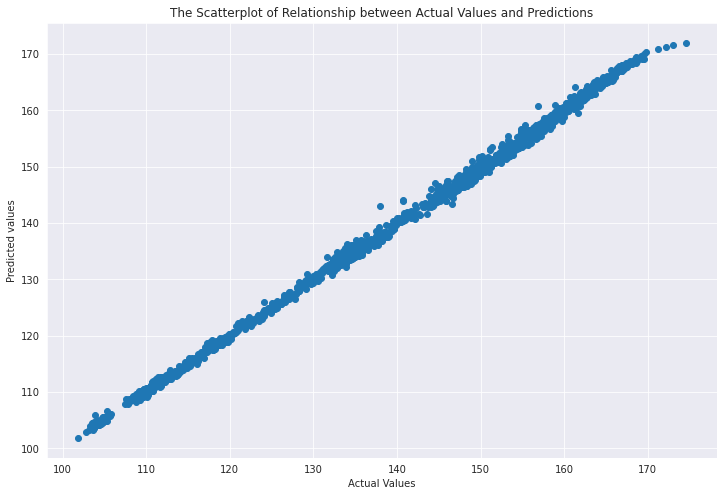

In [ ]:
plt.figure(figsize=(12,8))
plt.xlabel("Actual Values")
plt.ylabel("Predicted values")
plt.title("The Scatterplot of Relationship between Actual Values and Predictions")
plt.scatter(predictions_df['Actual'], predictions_df['Predicted'])

In [ ]:
# We will evaluate our model performance by calculating the residual sum of squares and the explained variance score
from sklearn import metrics
print("MAE:",metrics.mean_absolute_error(y_test,y_predict_test))
print ("MSE:",metrics.mean_squared_error(y_test,y_predict_test))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test,y_predict_test)))

MAE: 0.421182247324193
MSE: 0.3354966395080584
RMSE: 0.5792207174368493


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_predict_test = model.predict(x_test_scaled)
y_predict_train = model.predict(x_train_scaled)
print('R2_score (train): ',r2_score(y_train, y_predict_train))
print('R2_score (test): ',r2_score(y_test, y_predict_test))


376/376 [==============================] - 1s 1ms/step
R2_score (train):  0.9984749149564021
R2_score (test):  0.9986601016345625


In [ ]:
#Evaluation of  the explained variance score (R^2)
print('This shows our model predict % {} of the target correctly'.format(np.round(metrics.explained_variance_score(y_test,y_predict_test)*100,2)))


This shows our model predict % 99.87 of the target correctly
